In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as ag
import torchvision
import torchvision.datasets as dsets
import torch.utils.data as dutils
import torchvision.transforms as transforms


In [2]:
transform =torchvision.transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set= dsets.CIFAR10(root = './data/', download = True,
                         transform= transform, train = True) ##transform to normalize image
text_set= dsets.CIFAR10(root = './data/', download = True,
                        transform= transform, train = False)

100%|██████████| 170498071/170498071 [00:12<00:00, 13224354.35it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In [3]:
batch_size = 512
train_loader = dutils.DataLoader(dataset = train_set, batch_size = batch_size,
                                 shuffle=True, drop_last=True, num_workers = 10, pin_memory=True) ## shuffle to mix data
text_loader = dutils.DataLoader(dataset = text_set,batch_size=batch_size,
                                shuffle =False, drop_last = True, num_workers=10, pin_memory=True)

In [4]:
net = nn.Sequential(
    nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 1), #32x32x16
    nn.LeakyReLU(),
    nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 1, padding = 2), #32x32x32
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2), #16x16x32
    nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1), #16x16x64
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2), #8x8x64
    nn.Flatten(), #duoi cai tensor 3d thanh 1d (batchx4096x 1)
    nn.Linear(4096, 512), # 4096 input and 512 output
    nn.LeakyReLU(),
    nn.Linear(512, 512),
    nn.LeakyReLU(),
    nn.Linear(512,10), #batchx10
    nn.Softmax(dim=1)
)

In [5]:
%%timeit
for bi, (xi, yi) in enumerate(train_loader):
  xi = xi.to('cuda:0')

2.2 s ± 31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

def train(net, train_loader, text_loader, lr, epochs):
    lossf = nn.CrossEntropyLoss()
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    net.to(device)
    optimizer = optim.Adam(lr=lr, params=net.parameters())

    train_losses = []
    test_losses = []
    test_accs = []

    best_test_loss = float('inf')
    best_state_dict = None

    for ei in tqdm(range(epochs)):
        train_lossi = []
        for bi, (xi, yi) in enumerate(train_loader):
            optimizer.zero_grad()
            xi = xi.to(device)
            yi = yi.to(device)
            yi_hat = net(xi)
            lossi = lossf(yi_hat, yi)
            lossi.backward()
            optimizer.step()
            train_lossi.append(lossi.item())

        test_lossi = []
        correct = 0
        total = 0
        with torch.no_grad():
            for bti, (xti, yti) in enumerate(text_loader):
                xti = xti.to(device)
                yti = yti.to(device)
                yti_hat = net(xti)
                lossti = lossf(yti_hat, yti)
                test_lossi.append(lossti.item())
                yti_hat = yti_hat.argmax(dim=1)
                correct += (yti_hat == yti).sum().item()
                total += yti.size(0)

            acci = correct / total
            test_accs.append(acci)

        train_losses.append(torch.FloatTensor(train_lossi).mean().item())
        test_losses.append(torch.FloatTensor(test_lossi).mean().item())

        if test_losses[-1] < best_test_loss:
            best_test_loss = test_losses[-1]
            best_state_dict = net.state_dict()
        tqdm.write('train loss %.4f test loss %.4f test acc %.4f' % (train_losses[-1], test_losses[-1], test_accs[-1]))

    net.load_state_dict(best_state_dict)
    return net, train_losses, test_losses, test_accs


In [7]:
lr = 1e-3
epochs = 100

In [8]:
from keras import backend as K


In [9]:
if not 'r' in globals():
    print('Variable `r` is not defined. Please run the training code first.')

Variable `r` is not defined. Please run the training code first.


  1%|          | 1/100 [00:03<05:12,  3.15s/it]

train loss 1.5320 test loss 1.7473 test acc 0.7138


  2%|▏         | 2/100 [00:06<05:17,  3.24s/it]

train loss 1.5292 test loss 1.7543 test acc 0.7067


  3%|▎         | 3/100 [00:09<05:09,  3.19s/it]

train loss 1.5286 test loss 1.7403 test acc 0.7203


  4%|▍         | 4/100 [00:12<05:04,  3.17s/it]

train loss 1.5278 test loss 1.7435 test acc 0.7171


  5%|▌         | 5/100 [00:15<04:57,  3.14s/it]

train loss 1.5312 test loss 1.7459 test acc 0.7148


  6%|▌         | 6/100 [00:18<04:52,  3.11s/it]

train loss 1.5334 test loss 1.7469 test acc 0.7139


  7%|▋         | 7/100 [00:21<04:47,  3.09s/it]

train loss 1.5362 test loss 1.7471 test acc 0.7136


  8%|▊         | 8/100 [00:25<04:46,  3.12s/it]

train loss 1.5304 test loss 1.7426 test acc 0.7177


  9%|▉         | 9/100 [00:28<04:41,  3.09s/it]

train loss 1.5331 test loss 1.7525 test acc 0.7081


 10%|█         | 10/100 [00:31<04:37,  3.09s/it]

train loss 1.5359 test loss 1.7659 test acc 0.6948


 11%|█         | 11/100 [00:34<04:33,  3.07s/it]

train loss 1.5343 test loss 1.7525 test acc 0.7081


 12%|█▏        | 12/100 [00:37<04:32,  3.09s/it]

train loss 1.5352 test loss 1.7510 test acc 0.7097


 13%|█▎        | 13/100 [00:40<04:29,  3.09s/it]

train loss 1.5367 test loss 1.7479 test acc 0.7130


 14%|█▍        | 14/100 [00:43<04:24,  3.08s/it]

train loss 1.5388 test loss 1.7639 test acc 0.6970


 15%|█▌        | 15/100 [00:46<04:22,  3.08s/it]

train loss 1.5377 test loss 1.7467 test acc 0.7142


 16%|█▌        | 16/100 [00:49<04:22,  3.13s/it]

train loss 1.5339 test loss 1.7555 test acc 0.7053


 17%|█▋        | 17/100 [00:52<04:17,  3.10s/it]

train loss 1.5347 test loss 1.7586 test acc 0.7021


 18%|█▊        | 18/100 [00:55<04:14,  3.10s/it]

train loss 1.5369 test loss 1.7500 test acc 0.7107


 19%|█▉        | 19/100 [00:59<04:11,  3.10s/it]

train loss 1.5334 test loss 1.7473 test acc 0.7136


 20%|██        | 20/100 [01:02<04:07,  3.09s/it]

train loss 1.5329 test loss 1.7505 test acc 0.7101


 21%|██        | 21/100 [01:05<04:03,  3.08s/it]

train loss 1.5363 test loss 1.7504 test acc 0.7103


 22%|██▏       | 22/100 [01:08<04:00,  3.09s/it]

train loss 1.5386 test loss 1.7617 test acc 0.6988


 23%|██▎       | 23/100 [01:11<03:58,  3.10s/it]

train loss 1.5367 test loss 1.7546 test acc 0.7064


 24%|██▍       | 24/100 [01:14<03:56,  3.12s/it]

train loss 1.5382 test loss 1.7585 test acc 0.7025


 25%|██▌       | 25/100 [01:17<03:52,  3.10s/it]

train loss 1.5380 test loss 1.7488 test acc 0.7120


 26%|██▌       | 26/100 [01:20<03:49,  3.10s/it]

train loss 1.5356 test loss 1.7554 test acc 0.7057


 27%|██▋       | 27/100 [01:23<03:46,  3.10s/it]

train loss 1.5353 test loss 1.7611 test acc 0.6998


 28%|██▊       | 28/100 [01:26<03:42,  3.09s/it]

train loss 1.5360 test loss 1.7548 test acc 0.7060


 29%|██▉       | 29/100 [01:29<03:37,  3.07s/it]

train loss 1.5375 test loss 1.7507 test acc 0.7098


 30%|███       | 30/100 [01:33<03:34,  3.07s/it]

train loss 1.5417 test loss 1.7582 test acc 0.7026


 31%|███       | 31/100 [01:36<03:33,  3.09s/it]

train loss 1.5399 test loss 1.7511 test acc 0.7099


 32%|███▏      | 32/100 [01:39<03:29,  3.08s/it]

train loss 1.5414 test loss 1.7599 test acc 0.7012


 33%|███▎      | 33/100 [01:42<03:25,  3.07s/it]

train loss 1.5376 test loss 1.7587 test acc 0.7020


 34%|███▍      | 34/100 [01:45<03:21,  3.06s/it]

train loss 1.5384 test loss 1.7739 test acc 0.6872


 35%|███▌      | 35/100 [01:48<03:19,  3.08s/it]

train loss 1.5413 test loss 1.7548 test acc 0.7065


 36%|███▌      | 36/100 [01:51<03:17,  3.08s/it]

train loss 1.5418 test loss 1.7574 test acc 0.7038


 37%|███▋      | 37/100 [01:54<03:13,  3.06s/it]

train loss 1.5379 test loss 1.7450 test acc 0.7160


 38%|███▊      | 38/100 [01:57<03:09,  3.06s/it]

train loss 1.5482 test loss 1.7576 test acc 0.7031


 39%|███▉      | 39/100 [02:00<03:08,  3.09s/it]

train loss 1.5418 test loss 1.7689 test acc 0.6920


 40%|████      | 40/100 [02:03<03:05,  3.10s/it]

train loss 1.5393 test loss 1.7496 test acc 0.7112


 41%|████      | 41/100 [02:06<03:02,  3.09s/it]

train loss 1.5357 test loss 1.7551 test acc 0.7058


 42%|████▏     | 42/100 [02:09<02:58,  3.08s/it]

train loss 1.5415 test loss 1.7472 test acc 0.7138


 43%|████▎     | 43/100 [02:13<02:56,  3.10s/it]

train loss 1.5446 test loss 1.7512 test acc 0.7096


 44%|████▍     | 44/100 [02:16<02:54,  3.11s/it]

train loss 1.5372 test loss 1.7471 test acc 0.7141


 45%|████▌     | 45/100 [02:19<02:49,  3.08s/it]

train loss 1.5386 test loss 1.7505 test acc 0.7107


 46%|████▌     | 46/100 [02:22<02:47,  3.09s/it]

train loss 1.5497 test loss 1.7534 test acc 0.7075


 47%|████▋     | 47/100 [02:25<02:43,  3.09s/it]

train loss 1.5518 test loss 1.7703 test acc 0.6905


 48%|████▊     | 48/100 [02:28<02:40,  3.09s/it]

train loss 1.5530 test loss 1.7622 test acc 0.6986


 49%|████▉     | 49/100 [02:31<02:37,  3.09s/it]

train loss 1.5459 test loss 1.7541 test acc 0.7067


 50%|█████     | 50/100 [02:34<02:34,  3.09s/it]

train loss 1.5522 test loss 1.7651 test acc 0.6958


 51%|█████     | 51/100 [02:37<02:31,  3.09s/it]

train loss 1.5584 test loss 1.7925 test acc 0.6685


 52%|█████▏    | 52/100 [02:40<02:27,  3.08s/it]

train loss 1.5481 test loss 1.7589 test acc 0.7020


 53%|█████▎    | 53/100 [02:43<02:24,  3.07s/it]

train loss 1.5507 test loss 1.7643 test acc 0.6968


 54%|█████▍    | 54/100 [02:47<02:21,  3.08s/it]

train loss 1.5549 test loss 1.7617 test acc 0.6993


 55%|█████▌    | 55/100 [02:50<02:18,  3.08s/it]

train loss 1.5602 test loss 1.7697 test acc 0.6914


 56%|█████▌    | 56/100 [02:53<02:15,  3.08s/it]

train loss 1.5612 test loss 1.7695 test acc 0.6914


 57%|█████▋    | 57/100 [02:56<02:11,  3.06s/it]

train loss 1.5568 test loss 1.7608 test acc 0.7000


 58%|█████▊    | 58/100 [02:59<02:09,  3.09s/it]

train loss 1.5559 test loss 1.7561 test acc 0.7049


 59%|█████▉    | 59/100 [03:02<02:06,  3.10s/it]

train loss 1.5540 test loss 1.7744 test acc 0.6868


 60%|██████    | 60/100 [03:05<02:03,  3.09s/it]

train loss 1.5568 test loss 1.7697 test acc 0.6912


 61%|██████    | 61/100 [03:08<01:59,  3.08s/it]

train loss 1.5580 test loss 1.7762 test acc 0.6845


 62%|██████▏   | 62/100 [03:11<01:57,  3.08s/it]

train loss 1.5609 test loss 1.7684 test acc 0.6929


 63%|██████▎   | 63/100 [03:14<01:53,  3.08s/it]

train loss 1.5676 test loss 1.7629 test acc 0.6978


 64%|██████▍   | 64/100 [03:17<01:50,  3.07s/it]

train loss 1.5548 test loss 1.7600 test acc 0.7013


 65%|██████▌   | 65/100 [03:20<01:47,  3.07s/it]

train loss 1.5594 test loss 1.7687 test acc 0.6922


 66%|██████▌   | 66/100 [03:24<01:45,  3.09s/it]

train loss 1.5551 test loss 1.7669 test acc 0.6941


 67%|██████▋   | 67/100 [03:27<01:41,  3.09s/it]

train loss 1.5555 test loss 1.7629 test acc 0.6982


 68%|██████▊   | 68/100 [03:30<01:38,  3.09s/it]

train loss 1.5506 test loss 1.7632 test acc 0.6975


 69%|██████▉   | 69/100 [03:33<01:34,  3.06s/it]

train loss 1.5516 test loss 1.7582 test acc 0.7028


 70%|███████   | 70/100 [03:36<01:32,  3.09s/it]

train loss 1.5596 test loss 1.7697 test acc 0.6912


 71%|███████   | 71/100 [03:39<01:28,  3.07s/it]

train loss 1.5679 test loss 1.7700 test acc 0.6908


 72%|███████▏  | 72/100 [03:42<01:25,  3.06s/it]

train loss 1.5561 test loss 1.7781 test acc 0.6828


 73%|███████▎  | 73/100 [03:45<01:22,  3.05s/it]

train loss 1.5570 test loss 1.7638 test acc 0.6973


 74%|███████▍  | 74/100 [03:48<01:20,  3.08s/it]

train loss 1.5535 test loss 1.7771 test acc 0.6840


 75%|███████▌  | 75/100 [03:51<01:16,  3.07s/it]

train loss 1.5636 test loss 1.7892 test acc 0.6718


 76%|███████▌  | 76/100 [03:54<01:13,  3.07s/it]

train loss 1.5688 test loss 1.7711 test acc 0.6901


 77%|███████▋  | 77/100 [03:57<01:10,  3.07s/it]

train loss 1.5739 test loss 1.7743 test acc 0.6865


 78%|███████▊  | 78/100 [04:00<01:08,  3.10s/it]

train loss 1.5690 test loss 1.7652 test acc 0.6957


 79%|███████▉  | 79/100 [04:03<01:04,  3.08s/it]

train loss 1.5681 test loss 1.7758 test acc 0.6849


 80%|████████  | 80/100 [04:07<01:01,  3.08s/it]

train loss 1.5643 test loss 1.7664 test acc 0.6944


 81%|████████  | 81/100 [04:10<00:58,  3.08s/it]

train loss 1.5578 test loss 1.7544 test acc 0.7063


 82%|████████▏ | 82/100 [04:13<00:55,  3.08s/it]

train loss 1.5542 test loss 1.7603 test acc 0.7007


 83%|████████▎ | 83/100 [04:16<00:52,  3.06s/it]

train loss 1.5571 test loss 1.7781 test acc 0.6828


 84%|████████▍ | 84/100 [04:19<00:48,  3.05s/it]

train loss 1.5588 test loss 1.7622 test acc 0.6988


 85%|████████▌ | 85/100 [04:22<00:45,  3.06s/it]

train loss 1.5530 test loss 1.7614 test acc 0.6997


 86%|████████▌ | 86/100 [04:25<00:42,  3.07s/it]

train loss 1.5533 test loss 1.7576 test acc 0.7033


 87%|████████▋ | 87/100 [04:28<00:39,  3.07s/it]

train loss 1.5634 test loss 1.7629 test acc 0.6979


 88%|████████▊ | 88/100 [04:31<00:36,  3.07s/it]

train loss 1.5629 test loss 1.7811 test acc 0.6800


 89%|████████▉ | 89/100 [04:34<00:33,  3.06s/it]

train loss 1.5745 test loss 1.7847 test acc 0.6765


 90%|█████████ | 90/100 [04:37<00:30,  3.07s/it]

train loss 1.5653 test loss 1.7711 test acc 0.6899


 91%|█████████ | 91/100 [04:40<00:27,  3.07s/it]

train loss 1.5634 test loss 1.7707 test acc 0.6904


 92%|█████████▏| 92/100 [04:43<00:24,  3.06s/it]

train loss 1.5622 test loss 1.7581 test acc 0.7028


 93%|█████████▎| 93/100 [04:46<00:21,  3.09s/it]

train loss 1.5729 test loss 1.7773 test acc 0.6835


 94%|█████████▍| 94/100 [04:50<00:18,  3.09s/it]

train loss 1.5661 test loss 1.7607 test acc 0.7002


 95%|█████████▌| 95/100 [04:53<00:15,  3.09s/it]

train loss 1.5674 test loss 1.7731 test acc 0.6881


 96%|█████████▌| 96/100 [04:56<00:12,  3.09s/it]

train loss 1.5633 test loss 1.7646 test acc 0.6963


 97%|█████████▋| 97/100 [04:59<00:09,  3.10s/it]

train loss 1.5680 test loss 1.7615 test acc 0.6993


 98%|█████████▊| 98/100 [05:02<00:06,  3.09s/it]

train loss 1.5655 test loss 1.7635 test acc 0.6978


 99%|█████████▉| 99/100 [05:05<00:03,  3.08s/it]

train loss 1.5685 test loss 1.7621 test acc 0.6990


100%|██████████| 100/100 [05:08<00:00,  3.09s/it]


train loss 1.5758 test loss 1.7547 test acc 0.7061


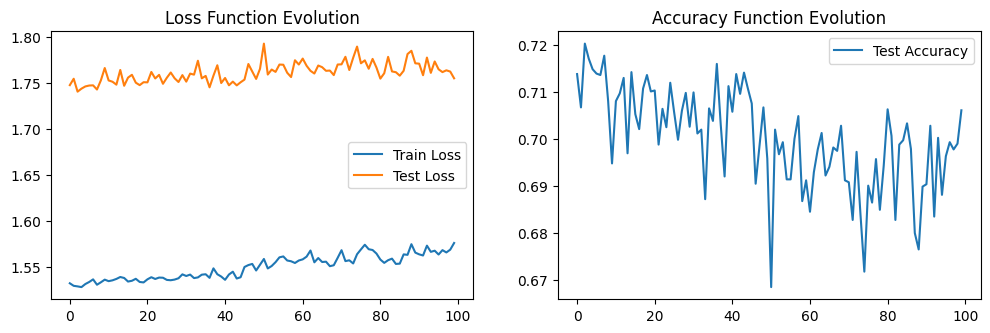

In [11]:
import matplotlib.pyplot as plt


net, train_losses, test_losses, test_accs = train(net, train_loader, text_loader, lr=lr, epochs=epochs)

plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()


plt.show()


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
